# Path Tracing Notebook
Implementation of Light Transport Algorithms

********************************************************************************************

In [5]:
import taichi as ti
ti.init(arch=ti.cpu, debug=True, random_seed=36279)

[Taichi] Starting on arch=arm64


In [6]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from taichi.math import vec3, cross, normalize

In [7]:
original_cornell_box = "../objects/cornell_box/CornellBox-Original.obj"
empty_cornell_box = "../objects/cornell_box/empty.obj"
cornell_box_sphere = "../objects/caustics/spheres/CornellBox-Water.obj"
cornell_box_water = "../objects/caustics/CornellBox-Water.obj"
sphere = "../objects/cornell_box/CornellBox-Sphere.obj"
test_scene = "../objects/untitled.obj"


# obj_path = test_scene
obj_path = sphere
mtl_path = obj_path.replace('.obj', '.mtl')

In [8]:
from utils.mesh import parse_scene, extract_material_data_from_mesh
import pyvista as pv

pv.set_jupyter_backend('trame')


vertices, faces, material_data = parse_scene(obj_path)

# Print material data
print("Material Data:")
print(material_data)

# Print vertices
print("\nVertices:")
print(vertices)

# Print faces
print("\nFaces Array:")
print(faces)

# Now you can load vertices and faces_array into PyVista
# Example:
mesh = pv.PolyData(vertices, faces)


# Attach all material properties to the mesh
mesh.cell_data['face_idx'] = material_data['face_idx']
mesh.cell_data['diffuse'] = material_data['diffuse']
mesh.cell_data['ambient'] = material_data['ambient']
mesh.cell_data['specular'] = material_data['specular']
mesh.cell_data['emission'] = material_data['emission']
mesh.cell_data['shininess'] = material_data['shininess']
mesh.cell_data['ior'] = material_data['ior']
mesh.cell_data['opacity'] = material_data['opacity']
mesh.cell_data['illum'] = material_data['illum']
mesh.cell_data['is_light'] = material_data['is_light']

# Triangulate the mesh
triangulated_mesh = mesh.triangulate()

# Extract material data from the triangulated mesh
material_data = extract_material_data_from_mesh(triangulated_mesh)

# Print extracted material data to verify
print(material_data)



# Create the left mirror sphere
left_sphere_center = (-0.31, 0.495, 0.175)
left_sphere_radius = 0.495
left_sphere = pv.Sphere(radius=left_sphere_radius, center=left_sphere_center)

# Create the right transparent glass sphere
right_sphere_center = (0.49, 0.245, -0.225)
right_sphere_radius = 0.245
right_sphere = pv.Sphere(radius=right_sphere_radius, center=right_sphere_center)



# Visualize the triangulated mesh to check if colors are mapped properly
plotter = pv.Plotter()


# Set the initial camera position and focal point
plotter.camera_position = 'xy'  # Align the camera view


plotter.add_mesh(triangulated_mesh, scalars='diffuse', rgb=True, show_edges=True)


# Add the spheres to the plotter
# plotter.add_mesh(left_sphere, color='silver', specular=1.0, smooth_shading=True)  # Mirror-like sphere
# plotter.add_mesh(right_sphere, color='white', opacity=0.5, smooth_shading=True)  # Transparent sphere


# Reset the camera to automatically fit the scene
plotter.reset_camera()  # This does what "Reset camera" in the GUI does

# Show the plotter window
plotter.show()

# Extract the updated camera parameters after resetting the camera
camera_position = plotter.camera_position[0]  # Camera position
camera_focal_point = plotter.camera_position[1]  # Look-at point
camera_up_vector = plotter.camera.up  # Up direction

# Convert these to numpy arrays or Taichi vectors as needed
_position = np.array(camera_position)
_look_at = np.array(camera_focal_point)
_up = np.array(camera_up_vector)


Unimplemented OBJ format statement 'Tf' on line '    Tf 0.10 0.10 0.10'
Unimplemented OBJ format statement 'Tf' on line '	Tf 1.0000 1.0000 1.0000'
Unimplemented OBJ format statement 'g' on line 'g leftSphere'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 'g' on line 'g rightSphere'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 'g' on line 'g floor'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 'g' on line 'g ceiling'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 'g' on line 'g backWall'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 'g' on line 'g rightWall'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 'g' on line 'g leftWall'
Unimplemented OBJ format statement 's' on line 's 1'
Unimplemented OBJ format statement 'g' on line 'g light'
Uni

Material Data:
[(0, [0.01, 0.01, 0.01], [0.01 , 0.01 , 0.01 ], [0.95, 0.95, 0.95], [  0.,   0.,   0.], 1024., 1. , 1., 5, 0)
 (1, [0.01, 0.01, 0.01], [0.01 , 0.01 , 0.01 ], [0.95, 0.95, 0.95], [  0.,   0.,   0.], 1024., 1. , 1., 5, 0)
 (2, [0.01, 0.01, 0.01], [0.01 , 0.01 , 0.01 ], [0.95, 0.95, 0.95], [  0.,   0.,   0.], 1024., 1. , 1., 5, 0)
 ...
 (1, [0.75, 0.25, 0.25], [0.63 , 0.065, 0.05 ], [0.  , 0.  , 0.  ], [  0.,   0.,   0.],   10., 1. , 1., 2, 0)
 (0, [0.78, 0.78, 0.78], [0.78 , 0.78 , 0.78 ], [0.  , 0.  , 0.  ], [100., 100., 100.],   10., 1.5, 1., 1, 1)
 (1, [0.78, 0.78, 0.78], [0.78 , 0.78 , 0.78 ], [0.  , 0.  , 0.  ], [100., 100., 100.],   10., 1.5, 1., 1, 1)]

Vertices:
[[-0.4214  0.6584 -0.28  ]
 [-0.4214  0.6529 -0.34  ]
 [-0.4324  0.6529 -0.3389]
 ...
 [ 0.23    1.58    0.16  ]
 [-0.24    1.58    0.16  ]
 [-0.24    1.58   -0.22  ]]

Faces Array:
[   3    0    1 ... 1114 1115 1112]
[(   0, [0.01, 0.01, 0.01], [0.01 , 0.01 , 0.01 ], [0.95, 0.95, 0.95], [  0.,   0.,   0.],

Widget(value='<iframe src="http://localhost:49672/index.html?ui=P_0x17f0d3ed0_1&reconnect=auto" class="pyvista…

In [9]:
_position, _look_at, _up

(array([-0.01      ,  0.795     ,  6.30292746]),
 array([-0.01 ,  0.795, -0.025]),
 array([0., 1., 0.]))

In [10]:
print(triangulated_mesh.center)

[-0.010000000000000009, 0.795, -0.025000000000000022]


In [11]:
# Example: Check how many faces have illum=7
illum_1 = material_data[material_data['illum'] == 1].shape[0]
illum_2 = material_data[material_data['illum'] == 2].shape[0]
illum_5 = material_data[material_data['illum'] == 5].shape[0]
illum_7 = material_data[material_data['illum'] == 7].shape[0]

# Number of faces with illum=7
total_faces = material_data.shape[0]

# Print the result
print(total_faces==(illum_1+illum_2+illum_5+illum_7))
print(total_faces, illum_1, illum_2, illum_5, illum_7)

True
2188 2 10 1088 1088


In [12]:
# Extract vertices
vertices = triangulated_mesh.points.astype(np.float32)
n_vertices = vertices.shape[0]

# Extract faces directly after triangulation
faces = triangulated_mesh.faces.reshape(-1, 4)[:, 1:4]  # Reshape and remove the first column (number of points per face)
faces = faces.astype(np.int32)
n_faces = faces.shape[0]

n_triangles = n_faces

n_lights = illum_1  # assumed emissive surfaces have illum=2

print(n_triangles, n_faces, n_vertices)

2188 2188 1116


In [13]:
# Create Taichi fields
vertices_field = ti.Vector.field(3, dtype=ti.f32, shape=(n_vertices,))
faces_field = ti.Vector.field(3, dtype=ti.i32, shape=(n_faces,))

vertices_field.from_numpy(vertices)
faces_field.from_numpy(faces)

In [14]:
n_spheres = 0 #2 # will describe later
n_primitives = n_triangles + n_spheres

In [15]:
from primitives.primitives import Sphere

if n_spheres==0:
    sphere_field_size = 1
else:
    sphere_field_size = n_spheres

SS = ti.root.dense(ti.i, sphere_field_size)
spheres = Sphere.field()  # shape=(n_spheres)
SS.place(spheres)

<ti.SNode of type dense>

In [16]:
from base.materials import Material

# Create a Taichi field for the materials

MS = ti.root.dense(ti.i, n_triangles)
materials = Material.field()
MS.place(materials)

<ti.SNode of type dense>

In [17]:
from primitives.primitives import Primitive

# Create a Taichi field for the materials
PS = ti.root.dense(ti.i, n_primitives)
primitives = Primitive.field()
PS.place(primitives)

<ti.SNode of type dense>

In [18]:
from base.lights import DiffuseAreaLight

# Create a Taichi field for light sources
LS = ti.root.dense(ti.i, n_lights)
lights = DiffuseAreaLight.field()
LS.place(lights)

<ti.SNode of type dense>

In [19]:
# Extract the 'face_idx' field
face_idx = material_data['face_idx']

# Check if all 'face_idx' values are unique
are_unique = len(face_idx) == len(np.unique(face_idx))

print("All face_idx are unique:", are_unique)

All face_idx are unique: True


In [20]:
len(material_data) == n_primitives

True

In [21]:
materials.from_numpy(material_data)

In [22]:
materials[11]['face_idx'] == 11

True

In [23]:
lights.shape

(2,)

In [24]:
materials[0]

{'face_idx': <taichi.lang.field.SNodeHostAccess object at 0x340f81250>, 'diffuse': [0.009999999776482582, 0.009999999776482582, 0.009999999776482582], 'ambient': [0.009999999776482582, 0.009999999776482582, 0.009999999776482582], 'specular': [0.949999988079071, 0.949999988079071, 0.949999988079071], 'emission': [0.0, 0.0, 0.0], 'shininess': <taichi.lang.field.SNodeHostAccess object at 0x341013c90>, 'ior': <taichi.lang.field.SNodeHostAccess object at 0x3410117d0>, 'opacity': <taichi.lang.field.SNodeHostAccess object at 0x341012f90>, 'illum': <taichi.lang.field.SNodeHostAccess object at 0x341012a90>, 'is_light': <taichi.lang.field.SNodeHostAccess object at 0x341013450>}

In [25]:
from utils.misc import max_component
from base.bsdf import BXDF_DIFFUSE_REFLECTION, BXDF_SPECULAR_REFLECTION, BXDF_DIFFUSE_TRANSMISSION, BXDF_SPECULAR_TRANSMISSION

@ti.kernel
def populate_shapes():
    light_idx = 0
    for i in range(primitives.shape[0]-n_spheres):
        # Set up the geometry for the primitive (triangle in this case)
        primitives[i].triangle.vertex_1 = vertices_field[faces_field[i][0]]
        primitives[i].triangle.vertex_2 = vertices_field[faces_field[i][1]]
        primitives[i].triangle.vertex_3 = vertices_field[faces_field[i][2]]
        primitives[i].triangle.centroid = (primitives[i].triangle.vertex_1 + primitives[i].triangle.vertex_2 + primitives[i].triangle.vertex_3) / 3.0
        primitives[i].triangle.edge_1 = primitives[i].triangle.vertex_2 - primitives[i].triangle.vertex_1
        primitives[i].triangle.edge_2 = primitives[i].triangle.vertex_3 - primitives[i].triangle.vertex_1
        primitives[i].triangle.normal = normalize(cross(primitives[i].triangle.edge_1, primitives[i].triangle.edge_2))

        # Initialize the BSDF frame
        # primitives[i].bsdf.init_frame(primitives[i].triangle.normal)

        primitives[i].bsdf.diffuse.type = 0
        primitives[i].bsdf.transmit.type = 1
        primitives[i].bsdf.dielectric.type = 2
        primitives[i].bsdf.conductor.type = 3
        primitives[i].bsdf.mirror.type = 4
        primitives[i].bsdf.specular.type = 5

        # Determine the BxDF type based on material properties
        illum = materials[i].illum

        # if illum == 0 or illum == 1:  # Diffuse materials
        #     primitives[i].bsdf.add_diffuse(materials[i].diffuse)
        # elif illum == 2:  # Diffuse + Specular (using Conductor BxDF for specular)
        #     roughness = 1.0 - (materials[i].shininess / 1000.0)
        #     primitives[i].bsdf.add_conductor(materials[i].diffuse, vec3(0.0), roughness)
        # elif illum == 3:  # Diffuse + Specular + Reflection (using Conductor BxDF)
        #     roughness = 1.0 - (materials[i].shininess / 1000.0)
        #     primitives[i].bsdf.add_conductor(materials[i].diffuse, vec3(0.0), roughness)
        # elif illum == 4 or illum == 6:  # Transparent materials (Dielectric BxDF)
        #     primitives[i].bsdf.add_dielectric(materials[i].ior, 0.0)  # Assume perfectly smooth dielectric
        # elif illum == 5 or illum == 7:  # Mirror reflection (using Conductor BxDF)
        #     primitives[i].bsdf.add_conductor(vec3(1.5), vec3(0.0), 0.0)  # Perfectly smooth conductor
        # else:  # Default to Diffuse
        #     primitives[i].bsdf.add_diffuse(materials[i].diffuse)

        if illum == 1 or illum == 2:  # Diffuse materials
            primitives[i].bsdf.add_diffuse(materials[i].diffuse)
        if illum == 5:  # Mirror materials
            primitives[i].bsdf.add_mirror(materials[i].specular)
        elif illum == 6:  # Metals (using Conductor BxDF)
            eta_silver = vec3(0.155, 0.116, 0.138)
            k_silver = vec3(4.828, 3.122, 2.146)
            roughness = 0.0
            primitives[i].bsdf.add_conductor(eta_silver, k_silver, roughness)
        elif illum == 7:  # Transparent materials (Dielectric BxDF)
            # primitives[i].bsdf.add_dielectric(materials[i].ior, materials[i].specular, 0.1)  # Assume perfectly smooth dielectric
            primitives[i].bsdf.add_dielectric(1.5, vec3([0.999, 0.999, 0.999]), 0.0)
        else:  # Default to Diffuse
            primitives[i].bsdf.add_diffuse(materials[i].diffuse)


        # Handle emissive materials (lights)
        if max_component(materials[i].emission) > 0:
            primitives[i].is_light = 1
            primitives[i].light_idx = light_idx
            lights[light_idx].shape_idx = i  # Link the light to the primitive
            lights[light_idx].two_sided = 0  # Assuming lights are one-sided
            lights[light_idx].Le = materials[i].emission
            light_idx += 1
        else:
            primitives[i].is_light = 0

        # Assign material to the primitive
        primitives[i].material = materials[i]

        # Set the shape type, assuming 0 is for triangle
        primitives[i].shape_type = 0

        if materials[i].face_idx == i:
            primitives[i].material = materials[i]
        else:
            print("face mismatch!!")

    print("Shapes populated:", primitives.shape[0])


# Call the kernel to populate the triangles
populate_shapes()

Shapes populated: 2188


In [26]:
@ti.kernel
def add_spheres():

    # Define the BSDF types for easy reference
    primitives[n_triangles].bsdf.diffuse.type = 0
    primitives[n_triangles].bsdf.transmit.type = 1
    primitives[n_triangles].bsdf.dielectric.type = 2
    primitives[n_triangles].bsdf.conductor.type = 3
    primitives[n_triangles].bsdf.mirror.type = 4
    primitives[n_triangles].bsdf.specular.type = 5

    # Add the left mirror sphere (Positioned on the left side of the box)
    primitives[n_triangles].shape_type = 1  # 1 indicates a sphere
    primitives[n_triangles].sphere.center = vec3([-0.31, 0.495, 0.175])
    primitives[n_triangles].sphere.radius = 0.495
    # primitives[n_triangles].sphere.center = vec3([-0.41, 0.395, -0.225])
    # primitives[n_triangles].sphere.radius = 0.4
    primitives[n_triangles].is_light = 0

    # Set up the material for the left mirror sphere
    primitives[n_triangles].material.diffuse = vec3([0.03, 0.03, 0.03])
    primitives[n_triangles].material.specular = vec3([0.999, 0.999, 0.999])
    primitives[n_triangles].material.emission = vec3([0.0, 0.0, 0.0])
    primitives[n_triangles].material.shininess = 1024.0
    primitives[n_triangles].material.ior = 1.0
    primitives[n_triangles].material.opacity = 1.0
    primitives[n_triangles].material.is_light = 0

    eta_silver = vec3(0.155, 0.116, 0.138)
    k_silver = vec3(4.828, 3.122, 2.146)
    roughness = 0.0

    # Set up the BSDF for the left mirror sphere
    primitives[n_triangles].bsdf.add_conductor(eta_silver, k_silver, roughness)



    # Define the BSDF types for easy reference
    primitives[n_triangles + 1].bsdf.diffuse.type = 0
    primitives[n_triangles + 1].bsdf.transmit.type = 1
    primitives[n_triangles + 1].bsdf.dielectric.type = 2
    primitives[n_triangles + 1].bsdf.conductor.type = 3
    primitives[n_triangles + 1].bsdf.mirror.type = 4
    primitives[n_triangles + 1].bsdf.specular.type = 5

    # Add the right transparent glass sphere (Positioned on the right side of the box)
    primitives[n_triangles + 1].shape_type = 1  # 1 indicates a sphere
    primitives[n_triangles + 1].sphere.center = vec3([0.49, 0.245, -0.225])
    primitives[n_triangles + 1].sphere.radius = 0.245
    # primitives[n_triangles + 1].sphere.center = vec3([0.49, 0.395, 0.175])
    # primitives[n_triangles + 1].sphere.radius = 0.4
    primitives[n_triangles + 1].is_light = 0  # Not a light source

    # Set up the material for the right transparent glass sphere
    primitives[n_triangles + 1].material.diffuse = vec3([0.01, 0.01, 0.01])
    primitives[n_triangles + 1].material.specular = vec3([0.999, 0.999, 0.999])
    primitives[n_triangles + 1].material.emission = vec3([0.0, 0.0, 0.0])
    primitives[n_triangles + 1].material.shininess = 1024.0
    primitives[n_triangles + 1].material.ior = 1.5
    primitives[n_triangles + 1].material.opacity = 0.1
    primitives[n_triangles + 1].material.is_light = 0

    # Set up the BSDF for the right transparent glass sphere
    primitives[n_triangles + 1].bsdf.add_dielectric(primitives[n_triangles + 1].material.ior, primitives[n_triangles + 1].material.specular, 0.0)
    # primitives[n_triangles + 1].bsdf.add_specular(primitives[n_triangles + 1].material.specular, primitives[n_triangles + 1].material.ior)

# Assuming `primitives` and `n_triangles` are defined globally
# add_spheres()


In [27]:
primitives[n_triangles-1].bsdf.type

0

In [28]:
lights[0].shape_idx

2186

In [29]:
# p_min = np.min(vertices)
# p_max = np.max(vertices)
#
# # centroid = vec3(bbox_center)
# centroid = mesh.center
#
# min_p = ti.field(dtype=ti.f32, shape=())
# min_p[None] = p_min
#
# centroid, min_p[None]

In [30]:
from primitives.aabb import AABB, BVHPrimitive

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
BS = ti.root.dense(ti.i, n_primitives)
bvh_primitives = BVHPrimitive.field()
BS.place(bvh_primitives)

@ti.kernel
def init_bounded_boxes():
    for i in ti.ndrange(n_primitives):
        bvh_primitives[i].prim = primitives[i]
        bvh_primitives[i].prim_num = i
        min_p, max_p = primitives[i].get_bounds()
        centroid = (min_p+max_p)/2
        bvh_primitives[i].bounds = AABB(min_point=min_p, max_point=max_p, centroid=centroid)

init_bounded_boxes()

bvh_primitives.shape[0], n_primitives

(2188, 2188)

In [31]:
# bounded_boxes[3]

In [32]:
OPS = ti.root.dense(ti.i, n_primitives)
ordered_prims = Primitive.field()
OPS.place(ordered_prims)

<ti.SNode of type dense>

In [33]:
from accelerators.bvh import BVHNode, BucketInfo

node_idx = 0

BVS = ti.root.dense(ti.i, 3 * n_primitives)
nodes = BVHNode.field()
BVS.place(nodes)


<ti.SNode of type dense>

In [34]:
nodes.shape[0]

6564

In [35]:

total_nodes = ti.field(ti.i32, shape=())
split_method = ti.field(ti.i32, shape=())
start = ti.field(ti.i32, shape=())
end = ti.field(ti.i32, shape=())
ordered_prims_idx = ti.field(ti.i32, shape=())
stack_ptr = ti.field(ti.i32, shape=())
# ordered_prims_size = ti.field(ti.i32, shape=())

@ti.kernel
def init_stack():
    total_nodes[None] = 0
    split_method[None] = 0
    start[None] = 0
    end[None] = n_primitives
    ordered_prims_idx[None] = 0
    stack_ptr[None] = 0
    # ordered_prims_size[None] = 0

init_stack()

In [36]:
stack = ti.field(ti.i32, shape=(3*n_primitives, 4))
n_buckets = 12
buckets = BucketInfo.field(shape=(n_buckets))
costs = ti.field(dtype=ti.f32, shape=(n_buckets-1))

In [37]:
primitives.shape[0], bvh_primitives.shape[0], start[None], end[None], ordered_prims.shape[0], nodes.shape[0], total_nodes[None], split_method[None], stack.shape, stack_ptr[None], ordered_prims_idx[None], costs.shape[0], buckets.shape[0]

(2188, 2188, 0, 2188, 2188, 6564, 0, 0, (6564, 4), 0, 0, 11, 12)

In [38]:
from accelerators.bvh import build_bvh

start_t = time.time()

build_bvh(primitives, bvh_primitives, start, end, ordered_prims, nodes, total_nodes, split_method, stack, stack_ptr, ordered_prims_idx, costs, buckets)

end_t = time.time()

In [39]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))
print(f"Total Nodes: {total_nodes}")

Elapsed (with compilation) = 0.3398878574371338
Total Nodes: 4299


In [40]:
total_nodes[None]

4299

In [41]:
from accelerators.bvh import LinearBVHNode
from accelerators.bvh import flatten_bvh

# create a linear representation of the bvh tree (empty)

LBVS = ti.root.dense(ti.i, total_nodes[None])
linear_bvh = LinearBVHNode.field()
LBVS.place(linear_bvh)

stack_size = 2 * n_primitives - 1  # Maximum possible stack size
stack3 = ti.Vector.field(3, dtype=ti.i32, shape=stack_size)
stack_top_2 = ti.field(dtype=ti.i32, shape=())

start_t = time.time()
total_nodes = flatten_bvh(nodes, linear_bvh, 0, stack3, stack_top_2)
end_t = time.time()
print(f"Total flattened nodes: {total_nodes}")

Total flattened nodes: 4299


In [42]:
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.023663043975830078


In [43]:
position = ti.Vector(_position.tolist()) # centroid + vec3([0.0, 0.0, min_p[None]*3])
look_at = ti.Vector(_look_at.tolist()) # normalize(centroid - position)
up = ti.Vector(_up.tolist()) # vec3([0.0, 1.0, 0.0])

In [44]:
from taichi.math import radians, tan
from base.frame import Frame, frame_from_z
from base.camera import PerspectiveCamera

camera = PerspectiveCamera.field(shape=())

width = 256
height = 256

# zoomed_position = ti.Vector.field(3, dtype=ti.f32, shape=())
# fov = ti.field(ti.f32, shape=())
# aspect_ratio = ti.field(ti.f32, shape=())
# lens_radius = ti.field(ti.f32, shape=())
# focal_distance = ti.field(ti.f32, shape=())
# screen_dx = ti.field(ti.f32, shape=())
# screen_dy = ti.field(ti.f32, shape=())
# dx_camera = ti.Vector.field(3, dtype=ti.f32, shape=())
# dy_camera = ti.Vector.field(3, dtype=ti.f32, shape=())
# frame = Frame.field(shape=())

@ti.kernel
def init_cam():
    camera.width[None] = width
    camera.height[None] = height
    camera.fov[None] = 30.0
    camera.aspect_ratio[None] = width / float(height)
    camera.lens_radius[None] = 0.00  # Set to a small value like 0.01 to test depth of field
    camera.focal_distance[None] = (look_at - position).norm()

    direction = (look_at - position).normalized()
    zoom_factor = 1.5  # + in / - out
    camera.position[None] = position + direction * zoom_factor

    # Setup the camera frame (z points towards the scene)
    z = (look_at - camera.position[None]).normalized()
    camera.frame[None] = frame_from_z(z)

    theta = radians(camera.fov[None])
    half_height = tan(theta / 2)
    half_width = camera.aspect_ratio[None] * half_height

    # Compute the screen dimensions in camera space
    camera.screen_dx[None] = 2 * half_width
    camera.screen_dy[None] = 2 * half_height

    # Compute the pixel size in camera space
    camera.dx_camera[None] = ti.Vector([camera.screen_dx[None] / width, 0.0, 0.0])
    camera.dy_camera[None] = ti.Vector([0.0, camera.screen_dy[None] / height, 0.0])


init_cam()

In [45]:
camera.frame[None]

{'x': [1.0, 0.0, 0.0], 'y': [0.0, -1.0, 0.0], 'z': [0.0, 0.0, -1.0]}

In [46]:
@ti.kernel
def test_camera():
    # Generate a ray
    s, t = 0.5, 0.5  # Center of the screen
    ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir = camera[None].generate_ray_differential(s, t)
    print(ray_origin, ray_dir, rx_origin, rx_dir, ry_origin, ry_dir)

test_camera()

[-0.010000, 0.795000, 4.802927] [0.000000, 0.000000, -1.000000] [-0.010000, 0.795000, 4.802927] [0.002093, 0.000000, -0.999998] [-0.010000, 0.795000, 4.802927] [0.000000, -0.002093, -0.999998]


In [47]:
from base.scene import Scene

pt = 0
mis = 1

# Instantiate a Scene object with the Camera object
scene = Scene(integrator=mis, spp=200, max_depth=14, sample_lights=1, sample_bsdf=1)

In [48]:
from base.render import render

# Initialize the image field outside the kernel using the actual values
image = ti.Vector.field(3, dtype=ti.f32, shape=(camera[None].width, camera[None].height))


start_t = time.time()

# Call the render_scene kernel
render(scene, image, lights, camera[None], primitives, linear_bvh)

end_t = time.time()

print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 47.42895793914795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


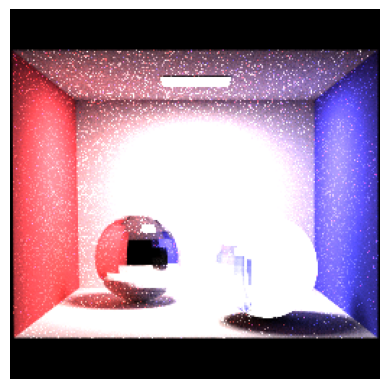

In [49]:
image_np = image.to_numpy()
# if np.isnan(image_np).any() or np.isinf(image_np).any():
#     print("Warning: NaN or Inf values detected in the image")
# image_np = np.clip(image_np, 0, 1)  # Clip values between 0 and 1
plt.imshow(image_np)
plt.axis('off')
plt.show()

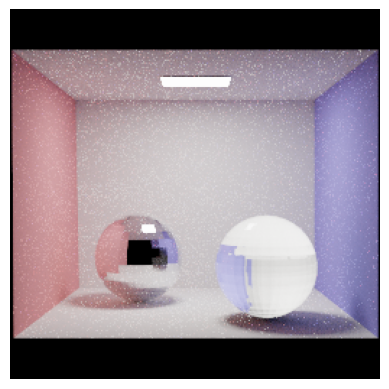

In [50]:
def tone_mapping(hdr_image, gamma=2.2):
    ldr_image = hdr_image / (1.0 + hdr_image)
    ldr_image = np.power(ldr_image, 1.0 / gamma)
    return np.clip(ldr_image, 0, 1)

ldr_image = tone_mapping(image_np)

# Display the tone-mapped image
plt.imshow(ldr_image)
plt.axis('off')
plt.show()